In [1]:
import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

In [2]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
#Importing Configs
# Define the path where config.py is located
#Mac
os.chdir('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling')
#Linux
#os.chdir('/home/kwnabors/Documents/GitHub/Finance-ML-Modeling')
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config

#Configs
database_file = config.database
database_folder = config.database_folder
bert_models = config.bert_models
bert_models_local = config.bert_models_local
Sentiment_models = config.Sentiment_models
finbert_models = config.finbert_models
database = config.Local_Database

Body = config.Body
Model = config.Model
Model_Subfolder = f'/{Body} Texts/{Model}'
#Model_Folder = config.texts
Model_Folder = config.Sentiment_models
Model_Folder = Model_Folder + Model_Subfolder
Model_Folder = config.Sentiment_models

Body_2 = config.Body_2
Model_2 = config.Model_2
Model_Subfolder_2 = f'/{Body_2} Texts/{Model_2}'
Model_Folder_2 = config.texts
Model_Folder_2 = Model_Folder_2 + Model_Subfolder_2


/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling
/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling
/Users/kylenabors/Documents
/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [4]:
# df1 = pd.read_csv(f"{finbert_models}/{Body}_{Model}_finbert_model_short.csv")
# df2 = pd.read_csv(f"{finbert_models}/{Body}_{Model}_finbert_model_short_2.csv")

df1 = pd.read_csv(f"{finbert_models}/{Body}/{Model}/{Body}_{Model}_finbert_model_short.csv")
df2 = pd.read_csv(f"{finbert_models}/{Body}/{Model}/{Body}_{Model}_finbert_model_short_2.csv")

In [5]:
ir1 = pd.read_csv(f"{database}/Other Data/2YIR.csv")
ir1 = ir1.rename(columns={'DATE': 'date', 'DGS2': 'IR2'})
df1 = df1.merge(ir1, how='left', on='date')
df2 = df2.merge(ir1, how='left', on='date')

In [6]:
print(df1.columns)
print(df2.columns)
print(df1.head())

Index(['Unnamed: 0', 'doc_num', 'date', 'title', 'segment', 'positive',
       'negative', 'neutral', 'sentiment', 'IR2'],
      dtype='object')
Index(['Unnamed: 0', 'doc_num', 'date', 'title', 'segment', 'tone', 'IR2'], dtype='object')
   Unnamed: 0 doc_num        date    title  \
0           0    Fed0  1998-07-01  minutes   
1           1    Fed0  1998-07-01  minutes   
2           2    Fed0  1998-07-01  minutes   
3           3    Fed0  1998-07-01  minutes   
4           4    Fed0  1998-07-01  minutes   

                                             segment  positive  negative  \
0  the manager of the system open market account ...    0.0792    0.0183   
1  the manager also reported on developments in d...    0.0873    0.0172   
2  the committee then turned to a discussion of t...    0.0358    0.0292   
3  a summary of the economic and financial inform...    0.0242    0.0254   
4  the information reviewed at this meeting sugge...    0.0229    0.9504   

   neutral  sentiment    IR2 

In [7]:
df_sent = df1.copy(deep=True)
df_sent = df1[['date', 'sentiment']]
df_sent = df_sent.groupby(['date']).mean()
df_sent['dup_number'] = df_sent.groupby(['date']).cumcount()+1
pivot = pd.pivot_table(df_sent, index='dup_number', columns='date', values ='sentiment', fill_value=None)

In [8]:
df_sent2 = df2.copy(deep=True)
df_sent2 = df2[['date', 'tone']]
df_sent2 = df_sent2.replace({'positive': 1, 'neutral' : 0, 'negative' : -1})
df_sent2 = df_sent2.groupby(['date']).mean()
df_sent2['dup_number'] = df_sent2.groupby(['date']).cumcount()+1
pivot2 = pd.pivot_table(df_sent2, index='dup_number', columns='date', values ='tone', fill_value=None)

In [9]:
df_var = df1[['date', 'sentiment']]
df_var = df_var.groupby(['date']).agg(["mean", "median", "var"]).reset_index()
df_var.columns = ['_'.join(col).strip() for col in df_var.columns.values]
df_var = df_var.rename(columns={'date_': 'date'})
df_var['sentiment_sd'] = df_var['sentiment_var']**0.5
df_var = df_var.rename(columns={'sentiment_sd': 'sd'})

df_var2 = df2[['date', 'tone']]
df_var2 = df_var2.replace({'positive': 1, 'neutral' : 0, 'negative' : -1})
df_var2 = df_var2.groupby(['date']).agg(["mean", "median", "var"]).reset_index()
df_var2.columns = ['_'.join(col).strip() for col in df_var2.columns.values]
df_var2 = df_var2.rename(columns={'date_': 'date'})
df_var2['tone_sd'] = df_var2['tone_var']**0.5
df_var2 = df_var2.rename(columns={'tone_sd': 'sd'})

In [10]:
# df1['date'] = df1['date'].str[0:7]
# df2['date'] = df2['date'].str[0:7]
df1 = df1[['date',  'positive', 'negative', 'neutral', 'sentiment']]

df1 = df1.groupby(['date']).mean().reset_index()
df2['tone'] = df2['tone'].replace({'positive': 1, 'neutral' : 0, 'negative' : -1})
df2 = df2[['date', 'tone']]
#df2 = df2.groupby(['date']).mean().reset_index()


In [11]:
df2['neg'] = df2['tone'].apply(lambda x: 1 if x < 0 else 0)
df2['pos'] = df2['tone'].apply(lambda x: 1 if x > 0 else 0)
df2['neu'] = df2['tone'].apply(lambda x: 1 if x == 0 else 0)

In [12]:

df_num_sent = df2.groupby('date')[['neg', 'neu', 'pos']].sum().reset_index()

#Add a column that is the sum of all the sentiments
df_num_sent['total'] = df_num_sent['neg'] + df_num_sent['neu'] + df_num_sent['pos']

df_num_sent['neg'] = df_num_sent['neg']/df_num_sent['total']
df_num_sent['neu'] = df_num_sent['neu']/df_num_sent['total']
df_num_sent['pos'] = df_num_sent['pos']/df_num_sent['total']

df_num_sent = df_num_sent.sort_values(by=['date'], ascending=True)

#df_num_sent['date'] = df_num_sent['date'].str[0:7]
df_num_sent = df_num_sent.groupby('date')[['neg', 'neu', 'pos']].mean().reset_index()
print(df_num_sent.head())

         date    neg    neu    pos
0  1998-07-01 0.4698 0.2685 0.2617
1  1998-08-18 0.4839 0.3032 0.2129
2  1998-09-29 0.4938 0.2750 0.2313
3  1998-11-17 0.4840 0.3351 0.1809
4  1998-12-22 0.3194 0.3681 0.3125


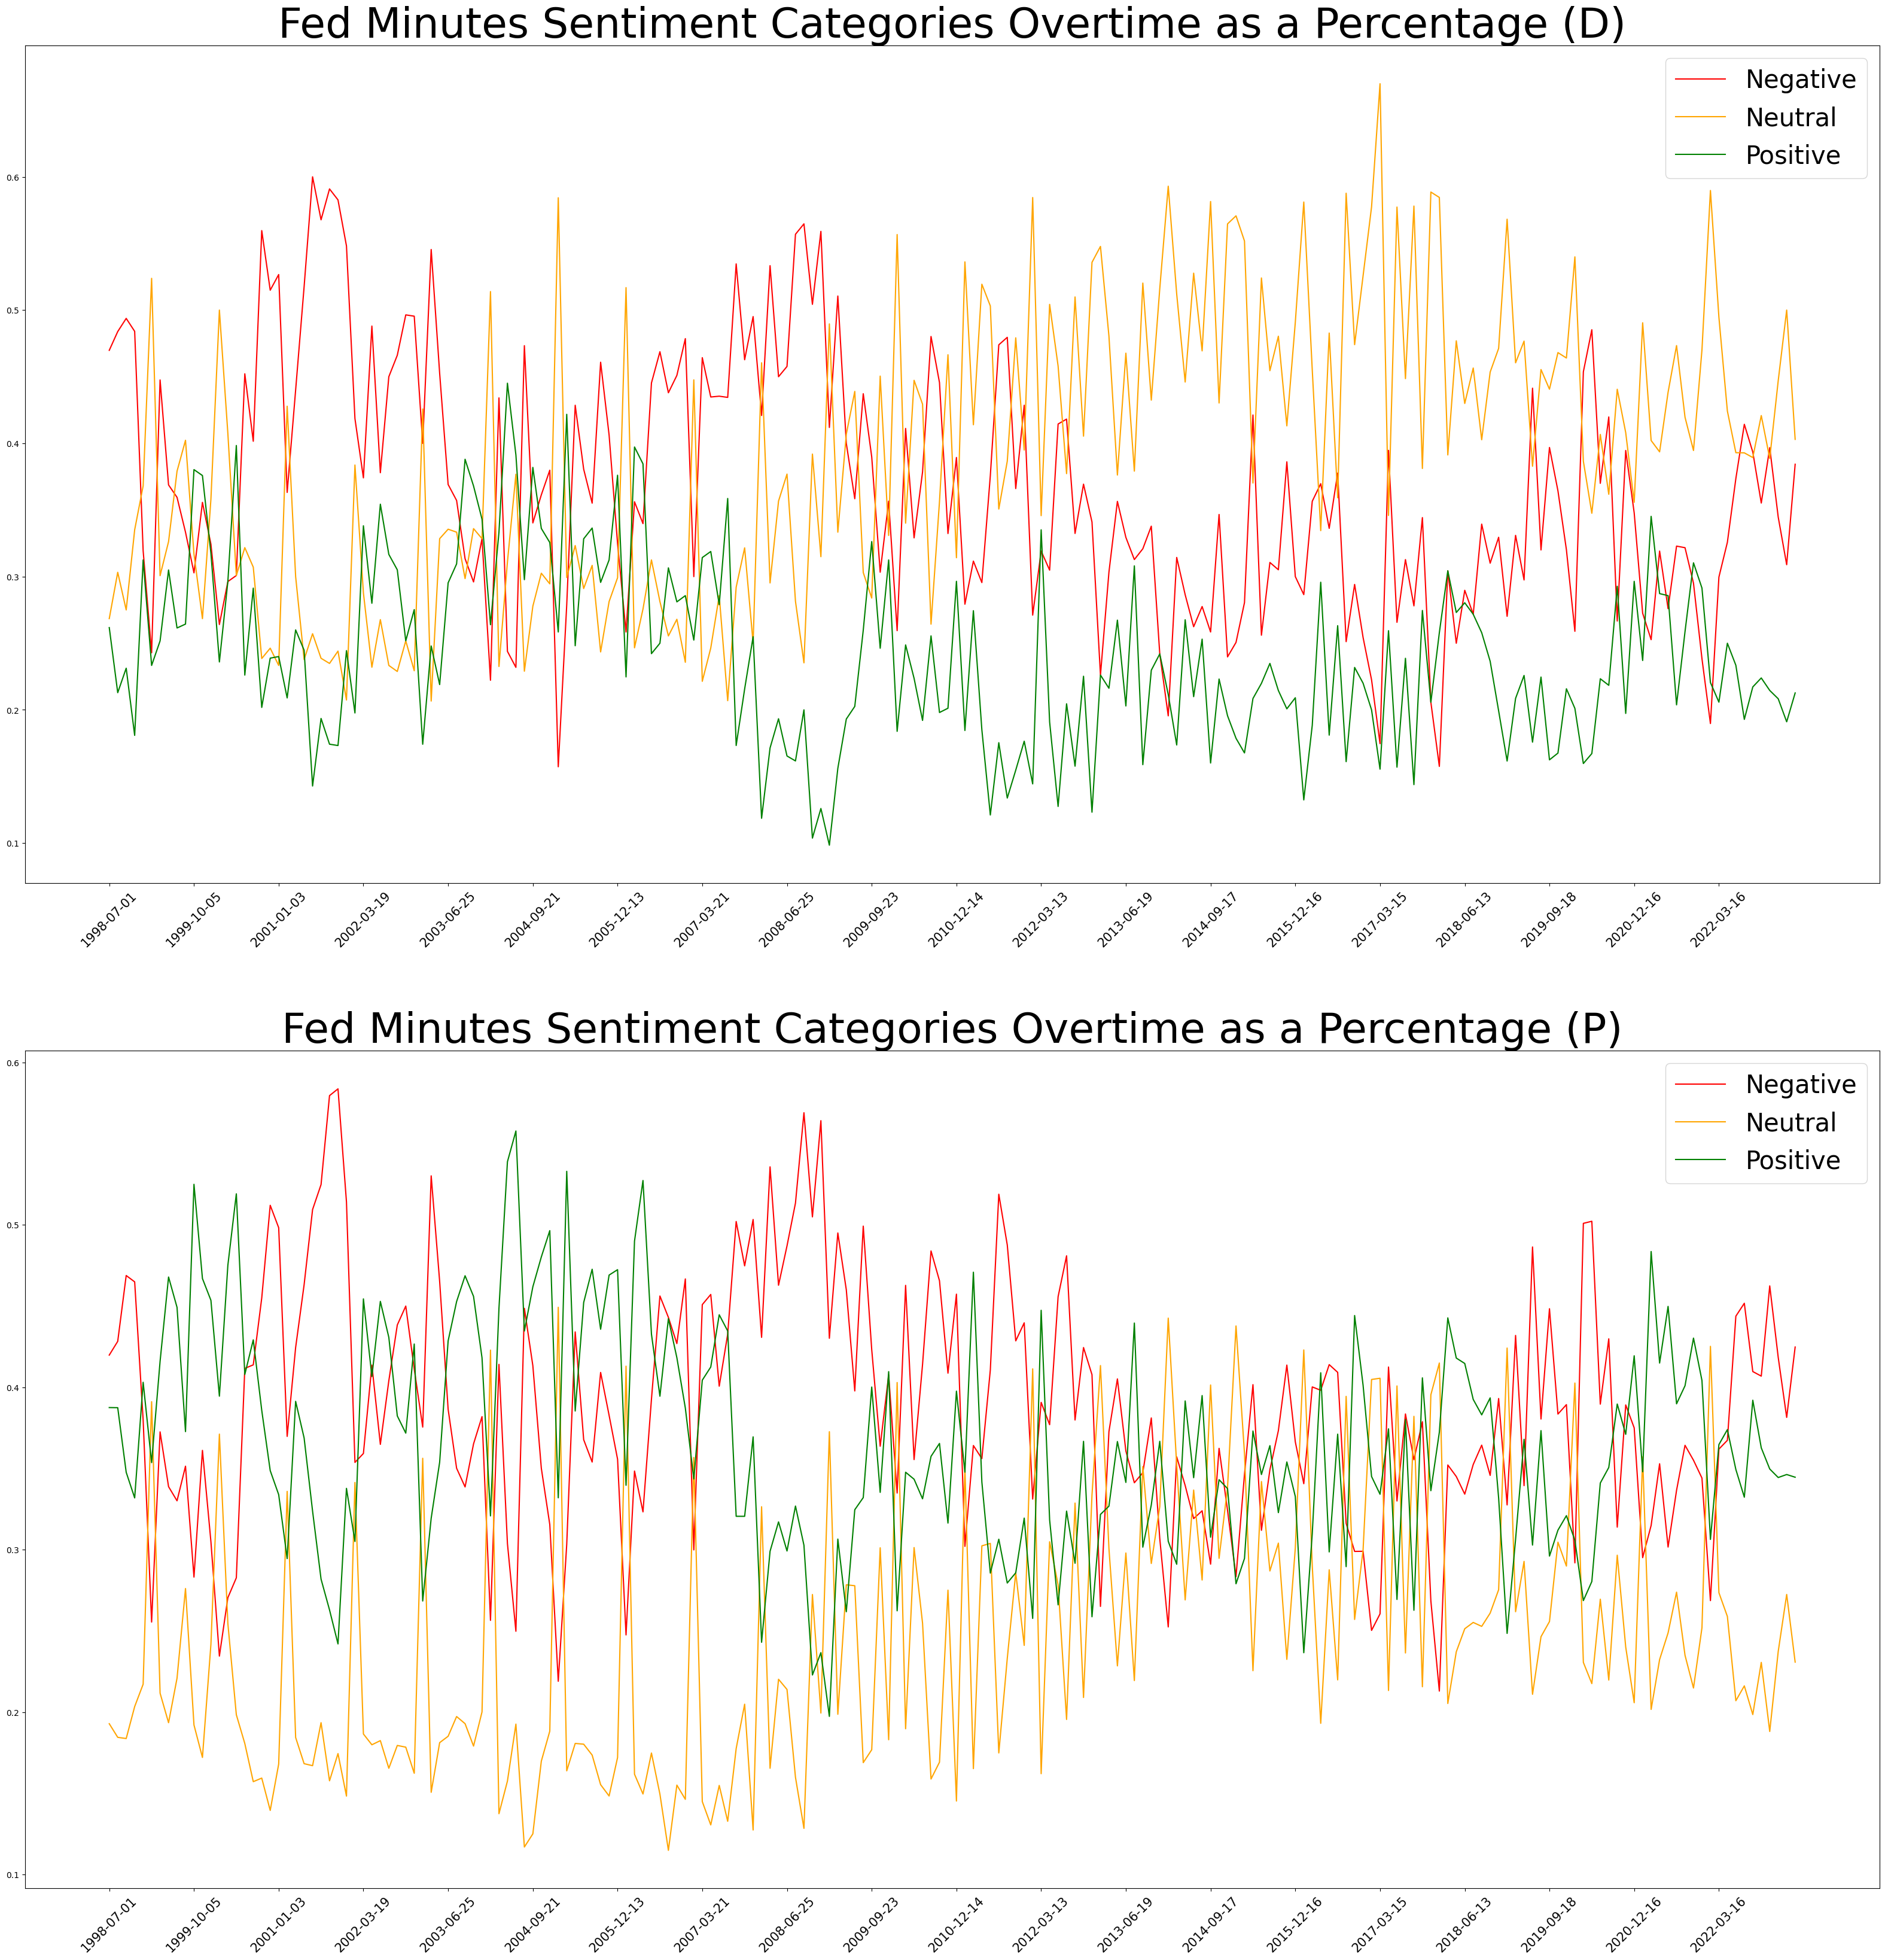

In [13]:
# Create a list of x-axis tick positions
num_ticks = 20 # Adjust this number as needed
x_tick_positions_0 = df_num_sent['date'].iloc[::len(df_num_sent) // num_ticks].tolist()
x_tick_positions_1 = df1['date'].iloc[::len(df1) // num_ticks].tolist()

fig, axs = plt.subplots(2, 1, figsize=(40, 40))

axs[0].plot(df_num_sent['date'], df_num_sent['neg'], color='red')
axs[0].plot(df_num_sent['date'], df_num_sent['neu'], color='orange')
axs[0].plot(df_num_sent['date'], df_num_sent['pos'], color='green')

axs[1].plot(df1['date'], df1['negative'], color='red')
axs[1].plot(df1['date'], df1['neutral'], color='orange')
axs[1].plot(df1['date'], df1['positive'], color='green')

# Set x-axis ticks for both subplots
axs[0].set_xticks(x_tick_positions_0)
axs[1].set_xticks(x_tick_positions_1)

axs[0].tick_params(axis='x', rotation=45, labelsize=15)
axs[1].tick_params(axis='x', rotation=45, labelsize=15)

axs[0].set_title(f'{Body} {Model} Sentiment Categories Overtime as a Percentage (D)', fontsize=50)
axs[1].set_title(f'{Body} {Model} Sentiment Categories Overtime as a Percentage (P)', fontsize=50)

axs[0].legend(['Negative', 'Neutral', 'Positive'], fontsize=30)
axs[1].legend(['Negative', 'Neutral', 'Positive'], fontsize=30)

plt.show()

In [14]:
#Replace IR2 values that are '.' with the next value
ir1['IR2'] = ir1['IR2'].replace('.', method='ffill')
ir1 = ir1[ir1['date'] >= df1['date'].min()]
ir1 =  ir1[ir1['date'] <= df1['date'].max()]
ir1['IR2'] = ir1['IR2'].astype(float)
print(df1['date'].min())
print(df1['date'].max())

1998-07-01
2023-05-03


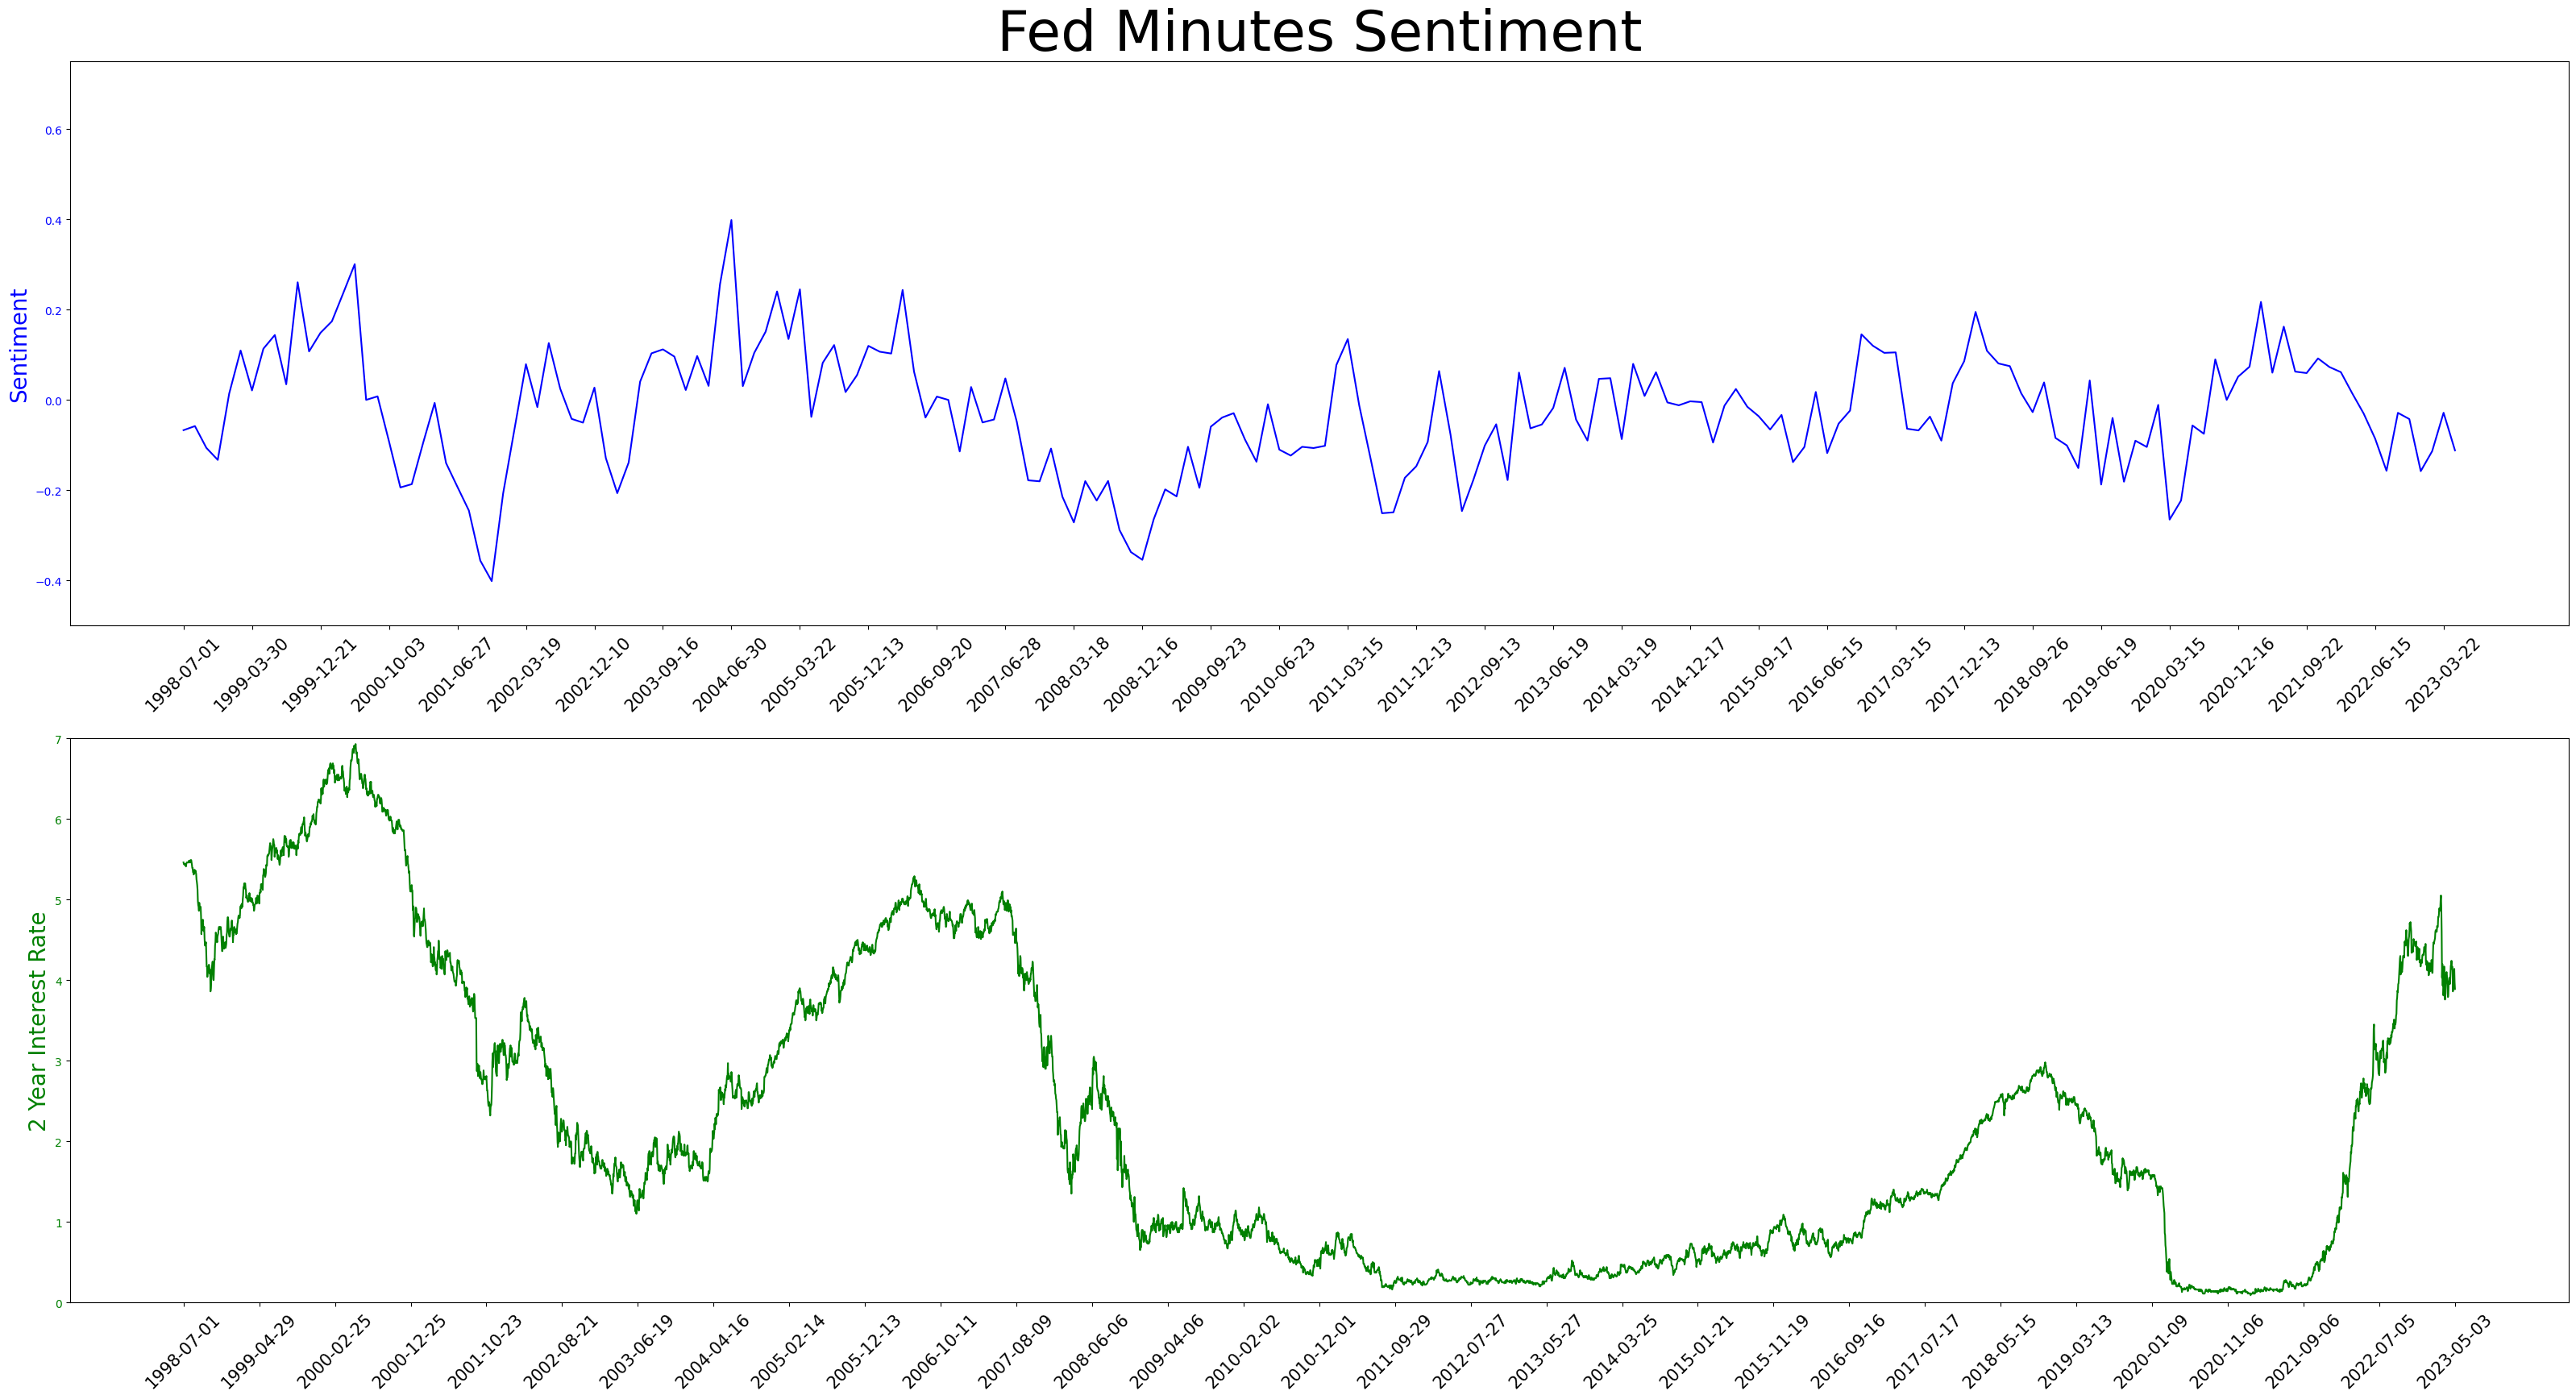

In [15]:

# Create a list of x-axis tick positions
num_ticks = 30  # Adjust this number as needed
x_tick_positions_0 = df1['date'].iloc[::len(df1) // num_ticks].tolist()
x_tick_positions_1 = ir1['date'].iloc[::len(ir1) // num_ticks].tolist()

fig, axs = plt.subplots(2, 1, figsize=(40, 20))
#axs = [axs, axs.twiny()]

axs[0].plot(df1['date'], df1['sentiment'], color='blue')

#axs[1] = axs[0].twinx()
axs[1].plot(ir1['date'], ir1['IR2'], color='green')

axs[0].tick_params(axis='y', labelcolor='blue')
axs[1].tick_params(axis='y', labelcolor='green')

# Set Y axis scales so that they both fit evenly on the chart
axs[0].set_ylim(-0.5, 0.75)
axs[1].set_ylim(0, 7)

axs[0].set_xticks(x_tick_positions_0)
axs[1].set_xticks(x_tick_positions_1)

axs[0].tick_params(axis='x', rotation=45, labelsize=15)
axs[1].tick_params(axis='x', rotation=45, labelsize=15)

axs[0].set_ylabel('Sentiment', color='blue', fontsize=20)
axs[1].set_ylabel('2 Year Interest Rate', color='green', fontsize=20)

axs[0].set_title(f'{Body} {Model} Sentiment', fontsize=50)

plt.show()

In [16]:
print(df1.head())
print(df_var.head())

         date  positive  negative  neutral  sentiment
0  1998-07-01    0.3874    0.4197   0.1928    -0.0671
1  1998-08-18    0.3874    0.4282   0.1844    -0.0581
2  1998-09-29    0.3476    0.4687   0.1837    -0.1062
3  1998-11-17    0.3318    0.4648   0.2034    -0.1330
4  1998-12-22    0.4030    0.3799   0.2171     0.0139
         date  sentiment_mean  sentiment_median  sentiment_var     sd
0  1998-07-01         -0.0671            0.0000         0.8063 0.8979
1  1998-08-18         -0.0581            0.0000         0.8213 0.9062
2  1998-09-29         -0.1062            0.0000         0.8251 0.9084
3  1998-11-17         -0.1330            0.0000         0.8004 0.8947
4  1998-12-22          0.0139            0.0000         0.7970 0.8928


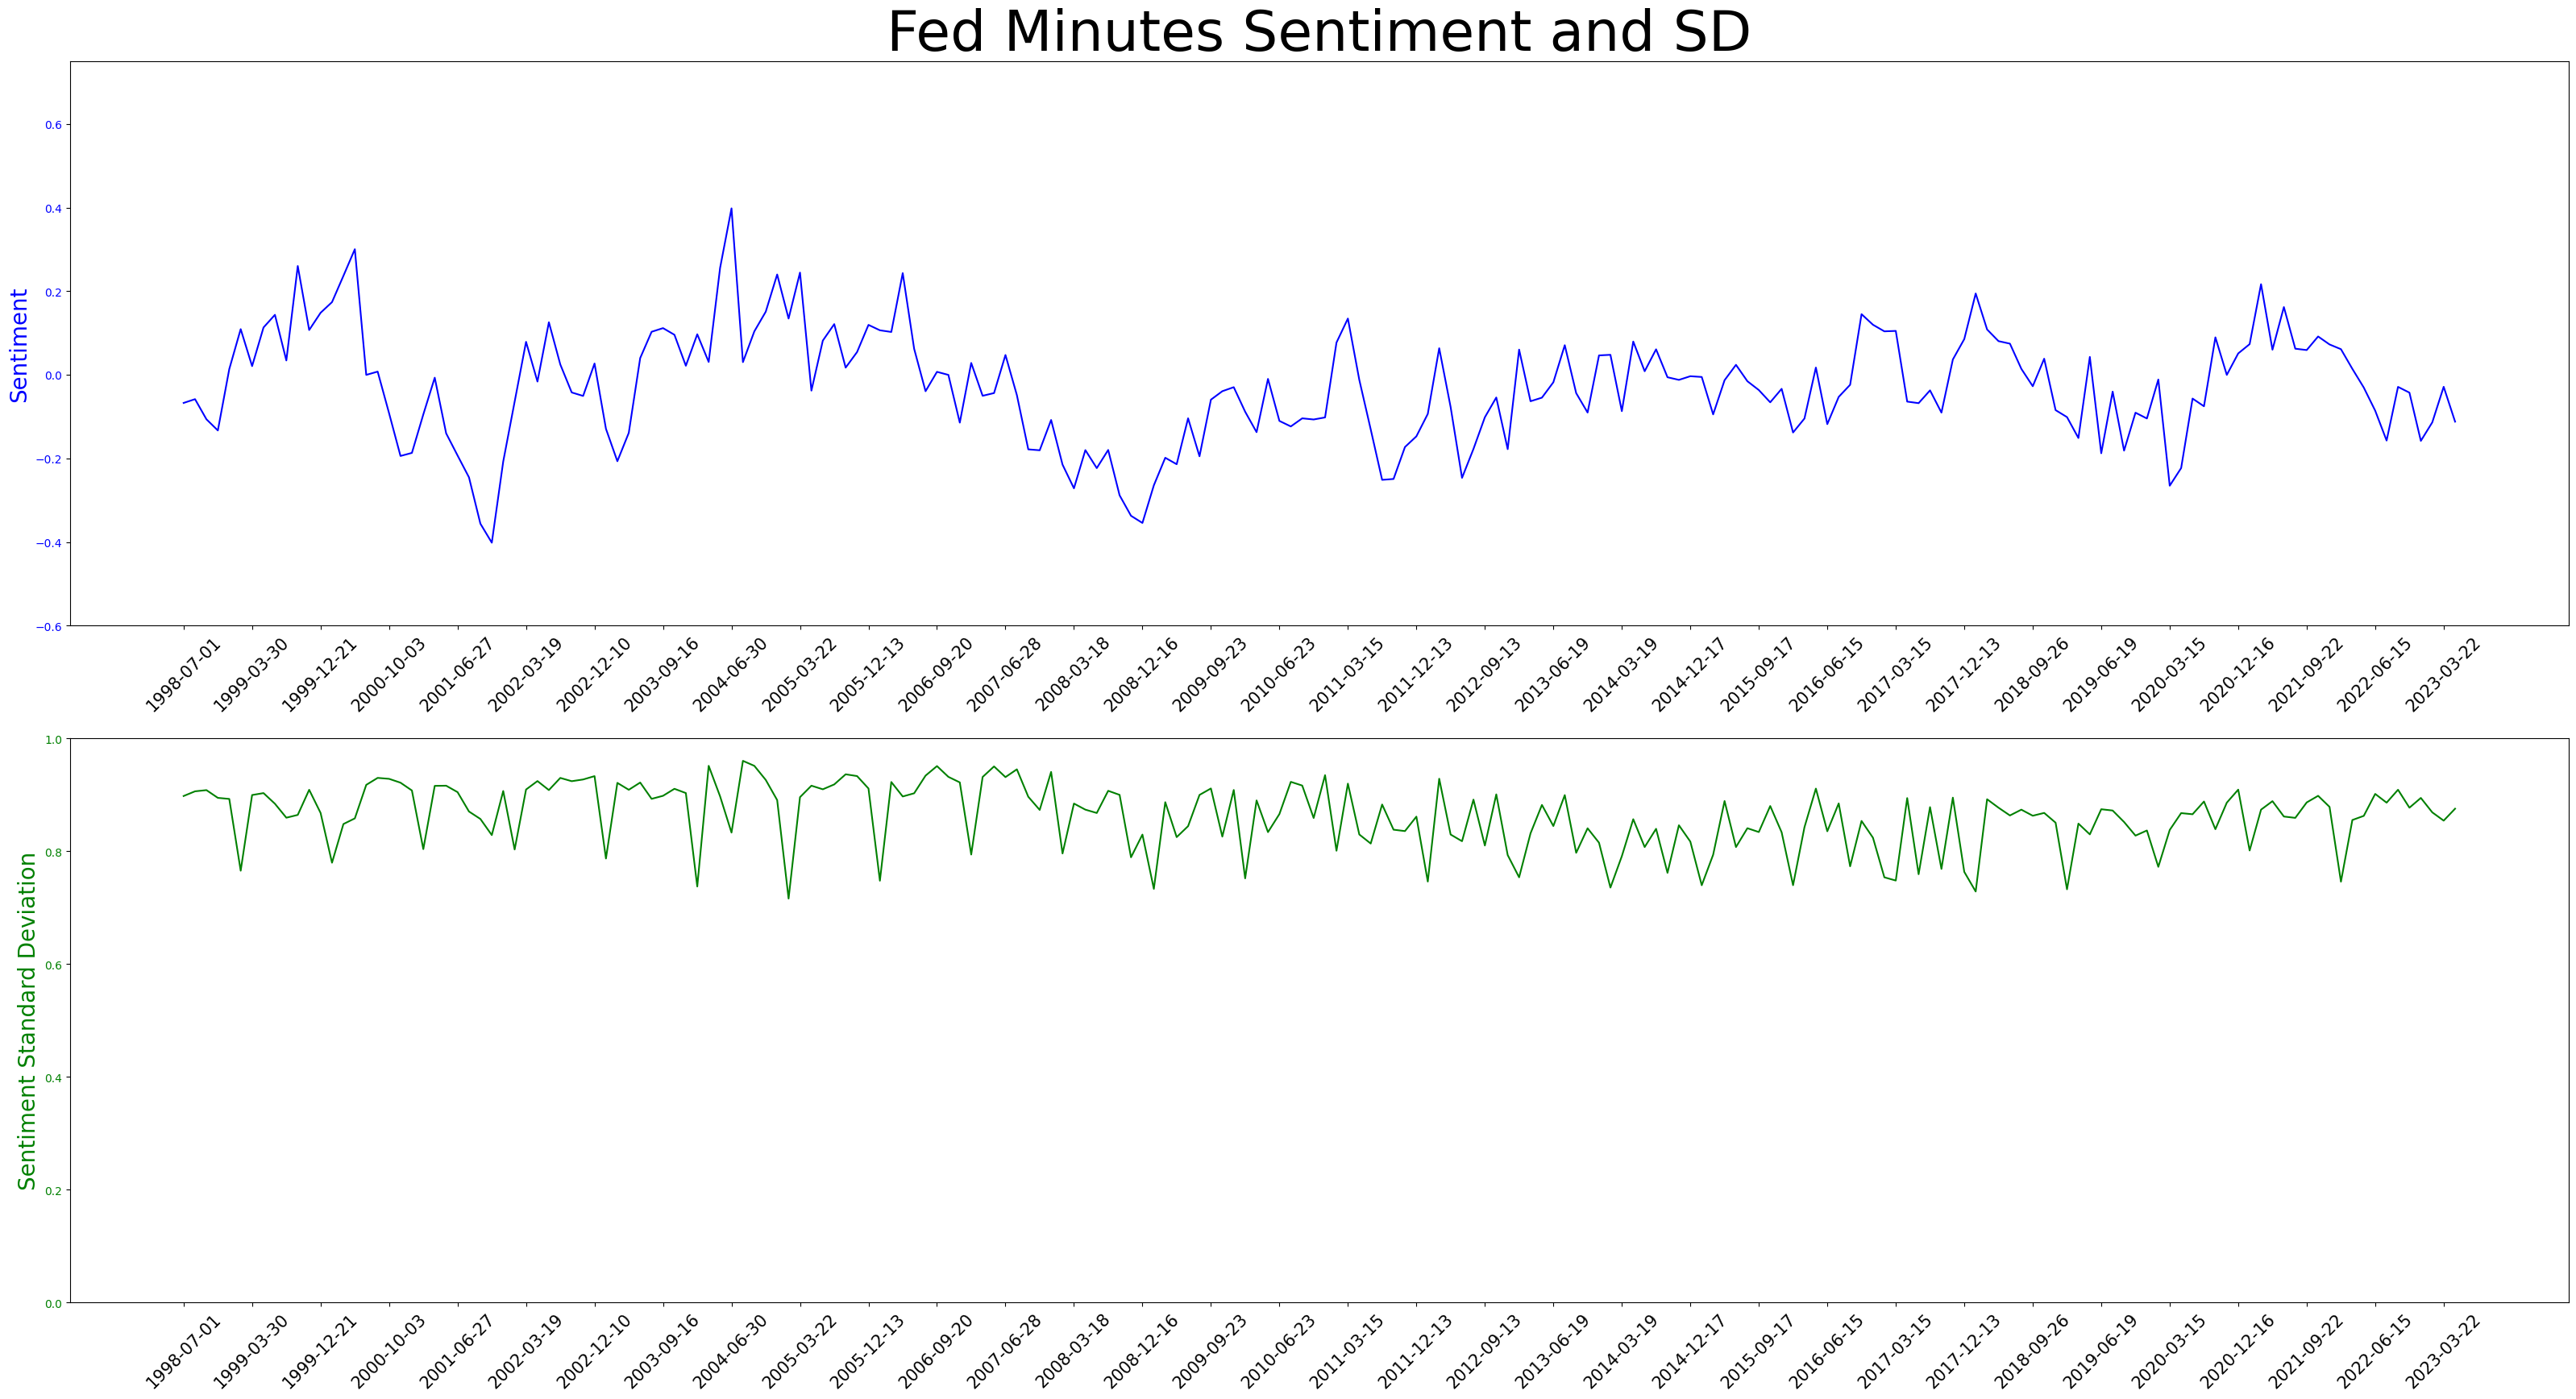

In [17]:

# Create a list of x-axis tick positions
num_ticks = 30  # Adjust this number as needed
x_tick_positions_0 = df1['date'].iloc[::len(df1) // num_ticks].tolist()
x_tick_positions_1 = df_var['date'].iloc[::len(df_var) // num_ticks].tolist()

fig, axs = plt.subplots(2, 1, figsize=(40, 20))
#axs = [axs, axs.twiny()]

axs[0].plot(df1['date'], df1['sentiment'], color='blue')

#axs[1] = axs[0].twinx()
axs[1].plot(df_var['date'], df_var['sd'], color='green')

axs[0].tick_params(axis='y', labelcolor='blue')
axs[1].tick_params(axis='y', labelcolor='green')

# Set Y axis scales so that they both fit evenly on the chart
axs[0].set_ylim(-0.6, 0.75)
axs[1].set_ylim(0, 1)

axs[0].set_xticks(x_tick_positions_0)
axs[1].set_xticks(x_tick_positions_1)

axs[0].tick_params(axis='x', rotation=45, labelsize=15)
axs[1].tick_params(axis='x', rotation=45, labelsize=15)

axs[0].set_ylabel('Sentiment', color='blue', fontsize=20)
axs[1].set_ylabel('Sentiment Standard Deviation', color='green', fontsize=20)

axs[0].set_title(f'{Body} {Model} Sentiment and SD', fontsize=50)

plt.show()

In [18]:
df_num_sent['diff'] = df_num_sent['pos'] - df_num_sent['neg']
df1['diff'] = df1['positive'] - df1['negative']

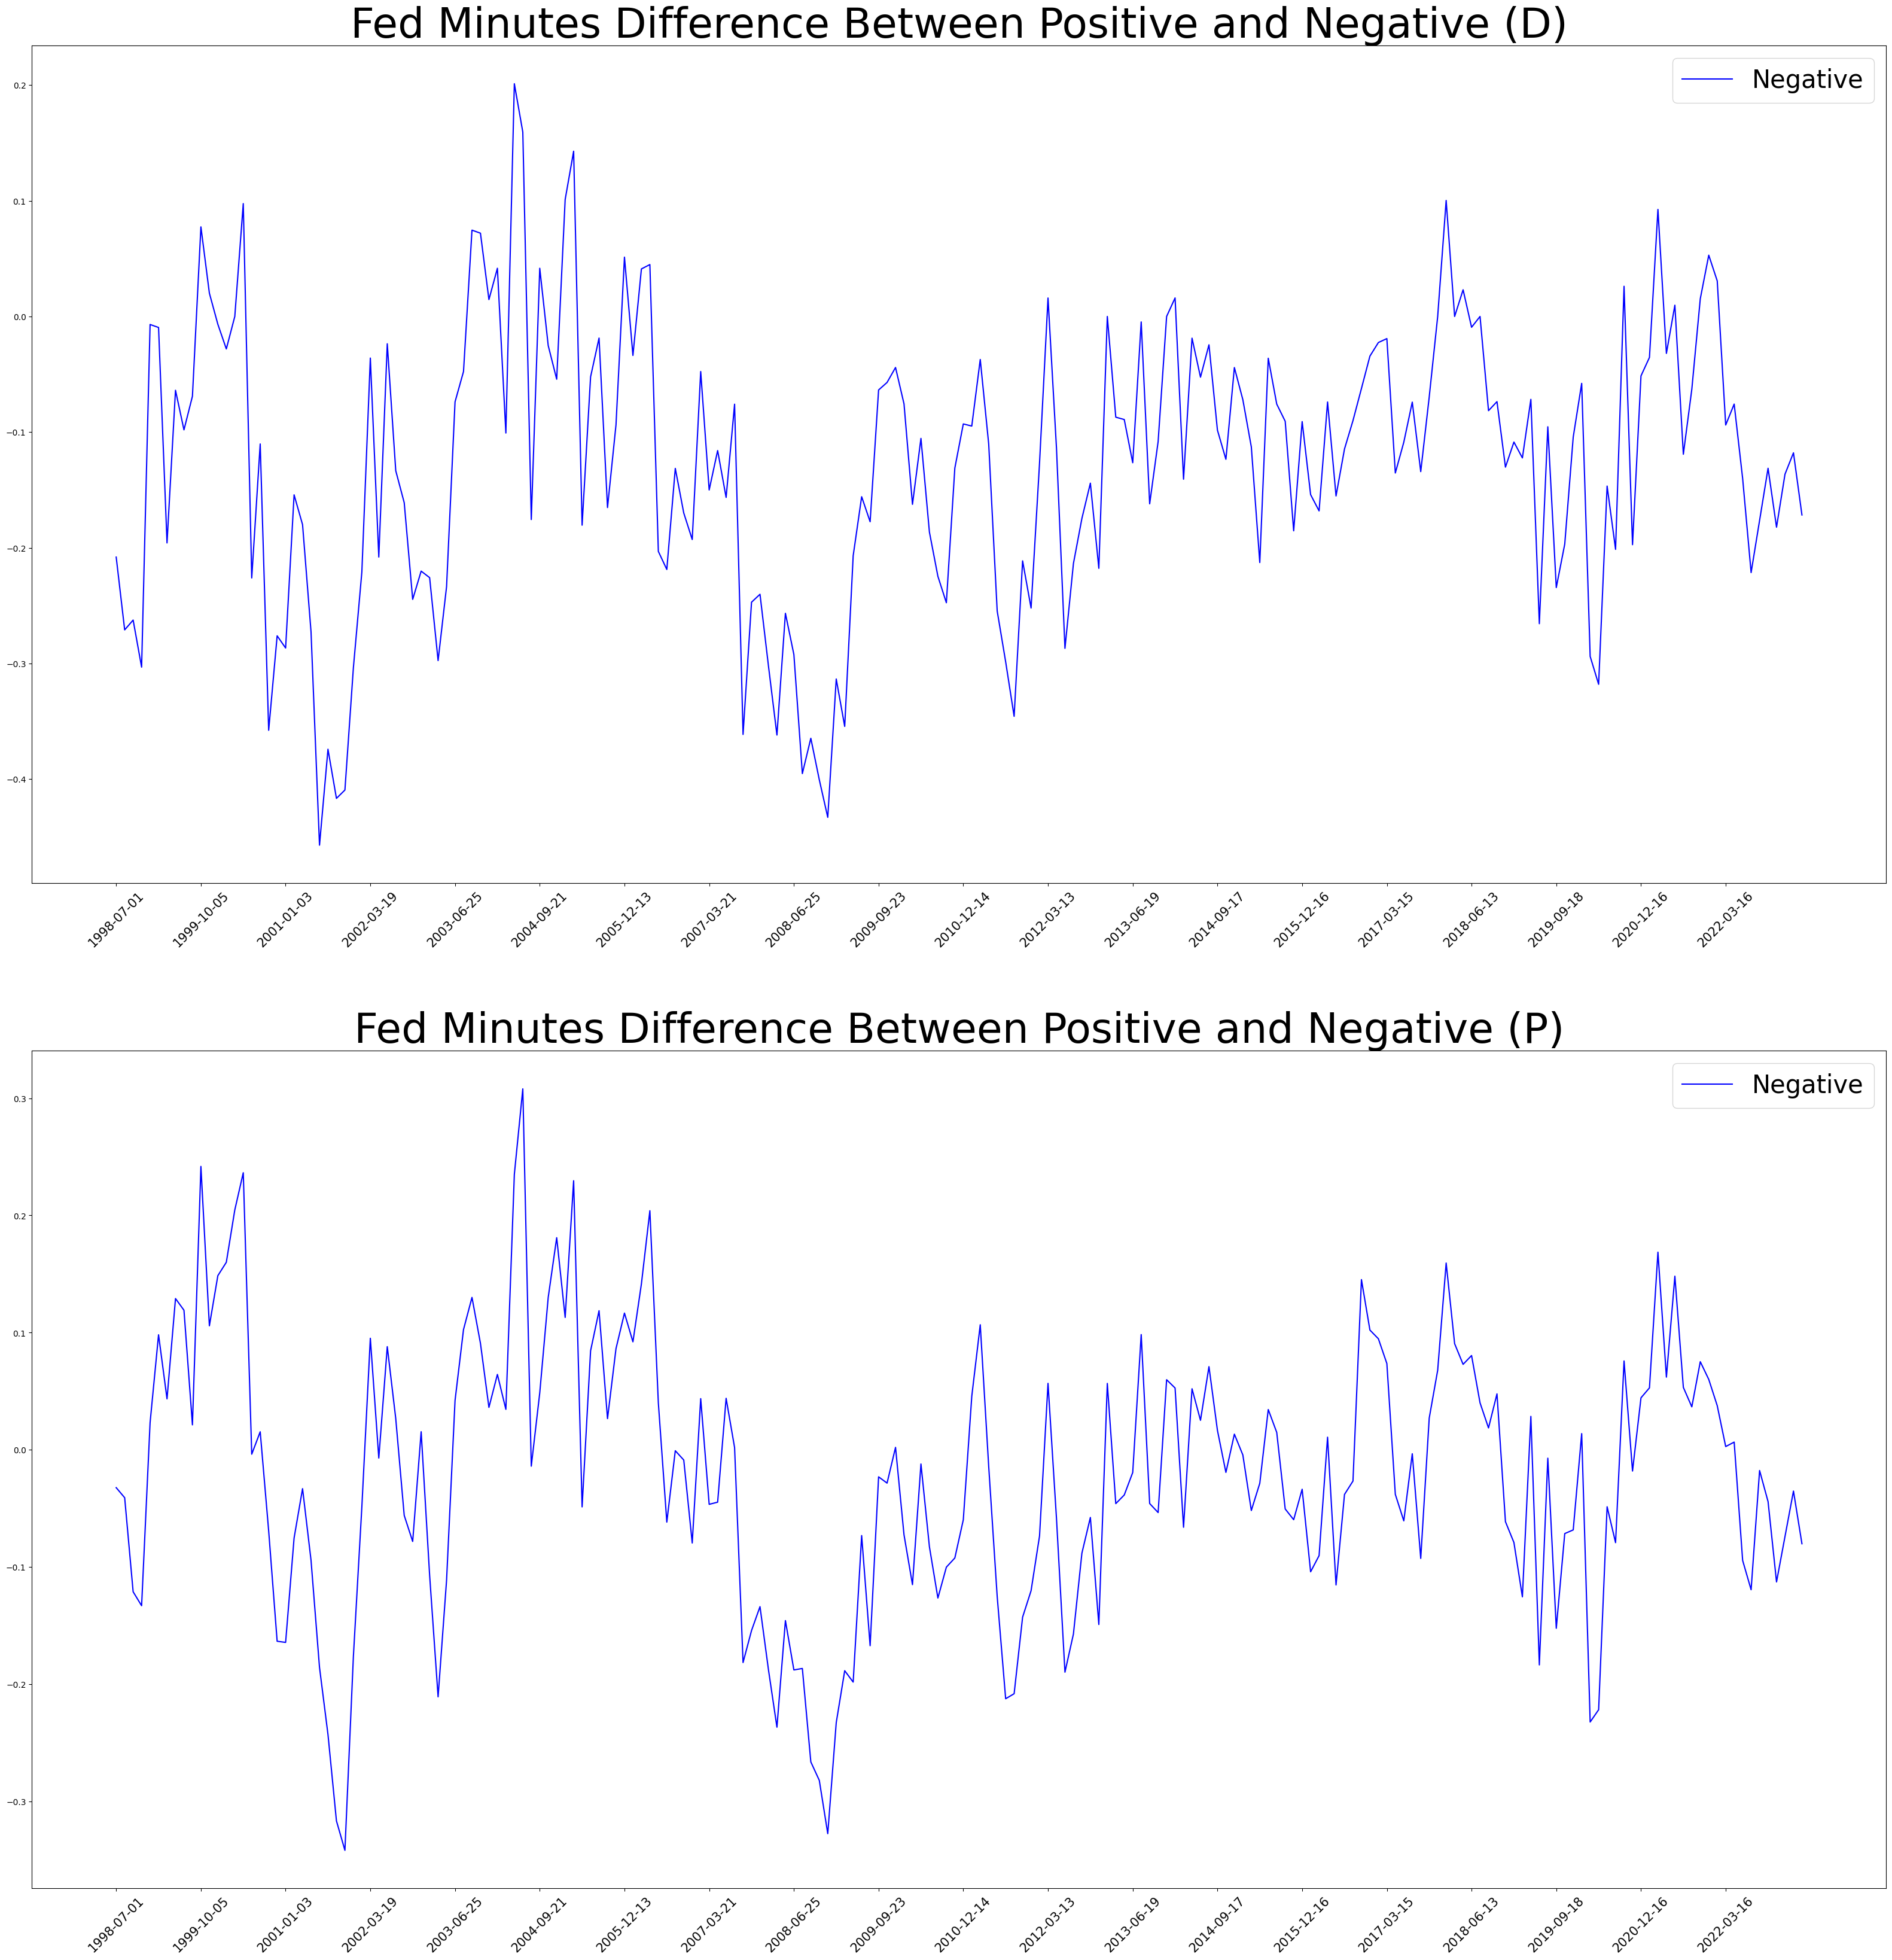

In [19]:
#Create a list of x-axis tick positions
num_ticks = 20  # Adjust this number as needed
x_tick_positions_0 = df_num_sent['date'].iloc[::len(df_num_sent) // num_ticks].tolist()
x_tick_positions_1 = df1['date'].iloc[::len(df1) // num_ticks].tolist()

fig, axs = plt.subplots(2, 1, figsize=(40, 40))

axs[0].plot(df_num_sent['date'], df_num_sent['diff'], color='blue')
axs[1].plot(df1['date'], df1['diff'], color='blue')

# Set x-axis ticks for both subplots
axs[0].set_xticks(x_tick_positions_0)
axs[1].set_xticks(x_tick_positions_1)

axs[0].tick_params(axis='x', rotation=45, labelsize=15)
axs[1].tick_params(axis='x', rotation=45, labelsize=15)

axs[0].set_title(f'{Body} {Model} Difference Between Positive and Negative (D)', fontsize=50)
axs[1].set_title(f'{Body} {Model} Difference Between Positive and Negative (P)', fontsize=50)

axs[0].legend(['Negative', 'Neutral', 'Positive'], fontsize=30)
axs[1].legend(['Negative', 'Neutral', 'Positive'], fontsize=30)

plt.show()

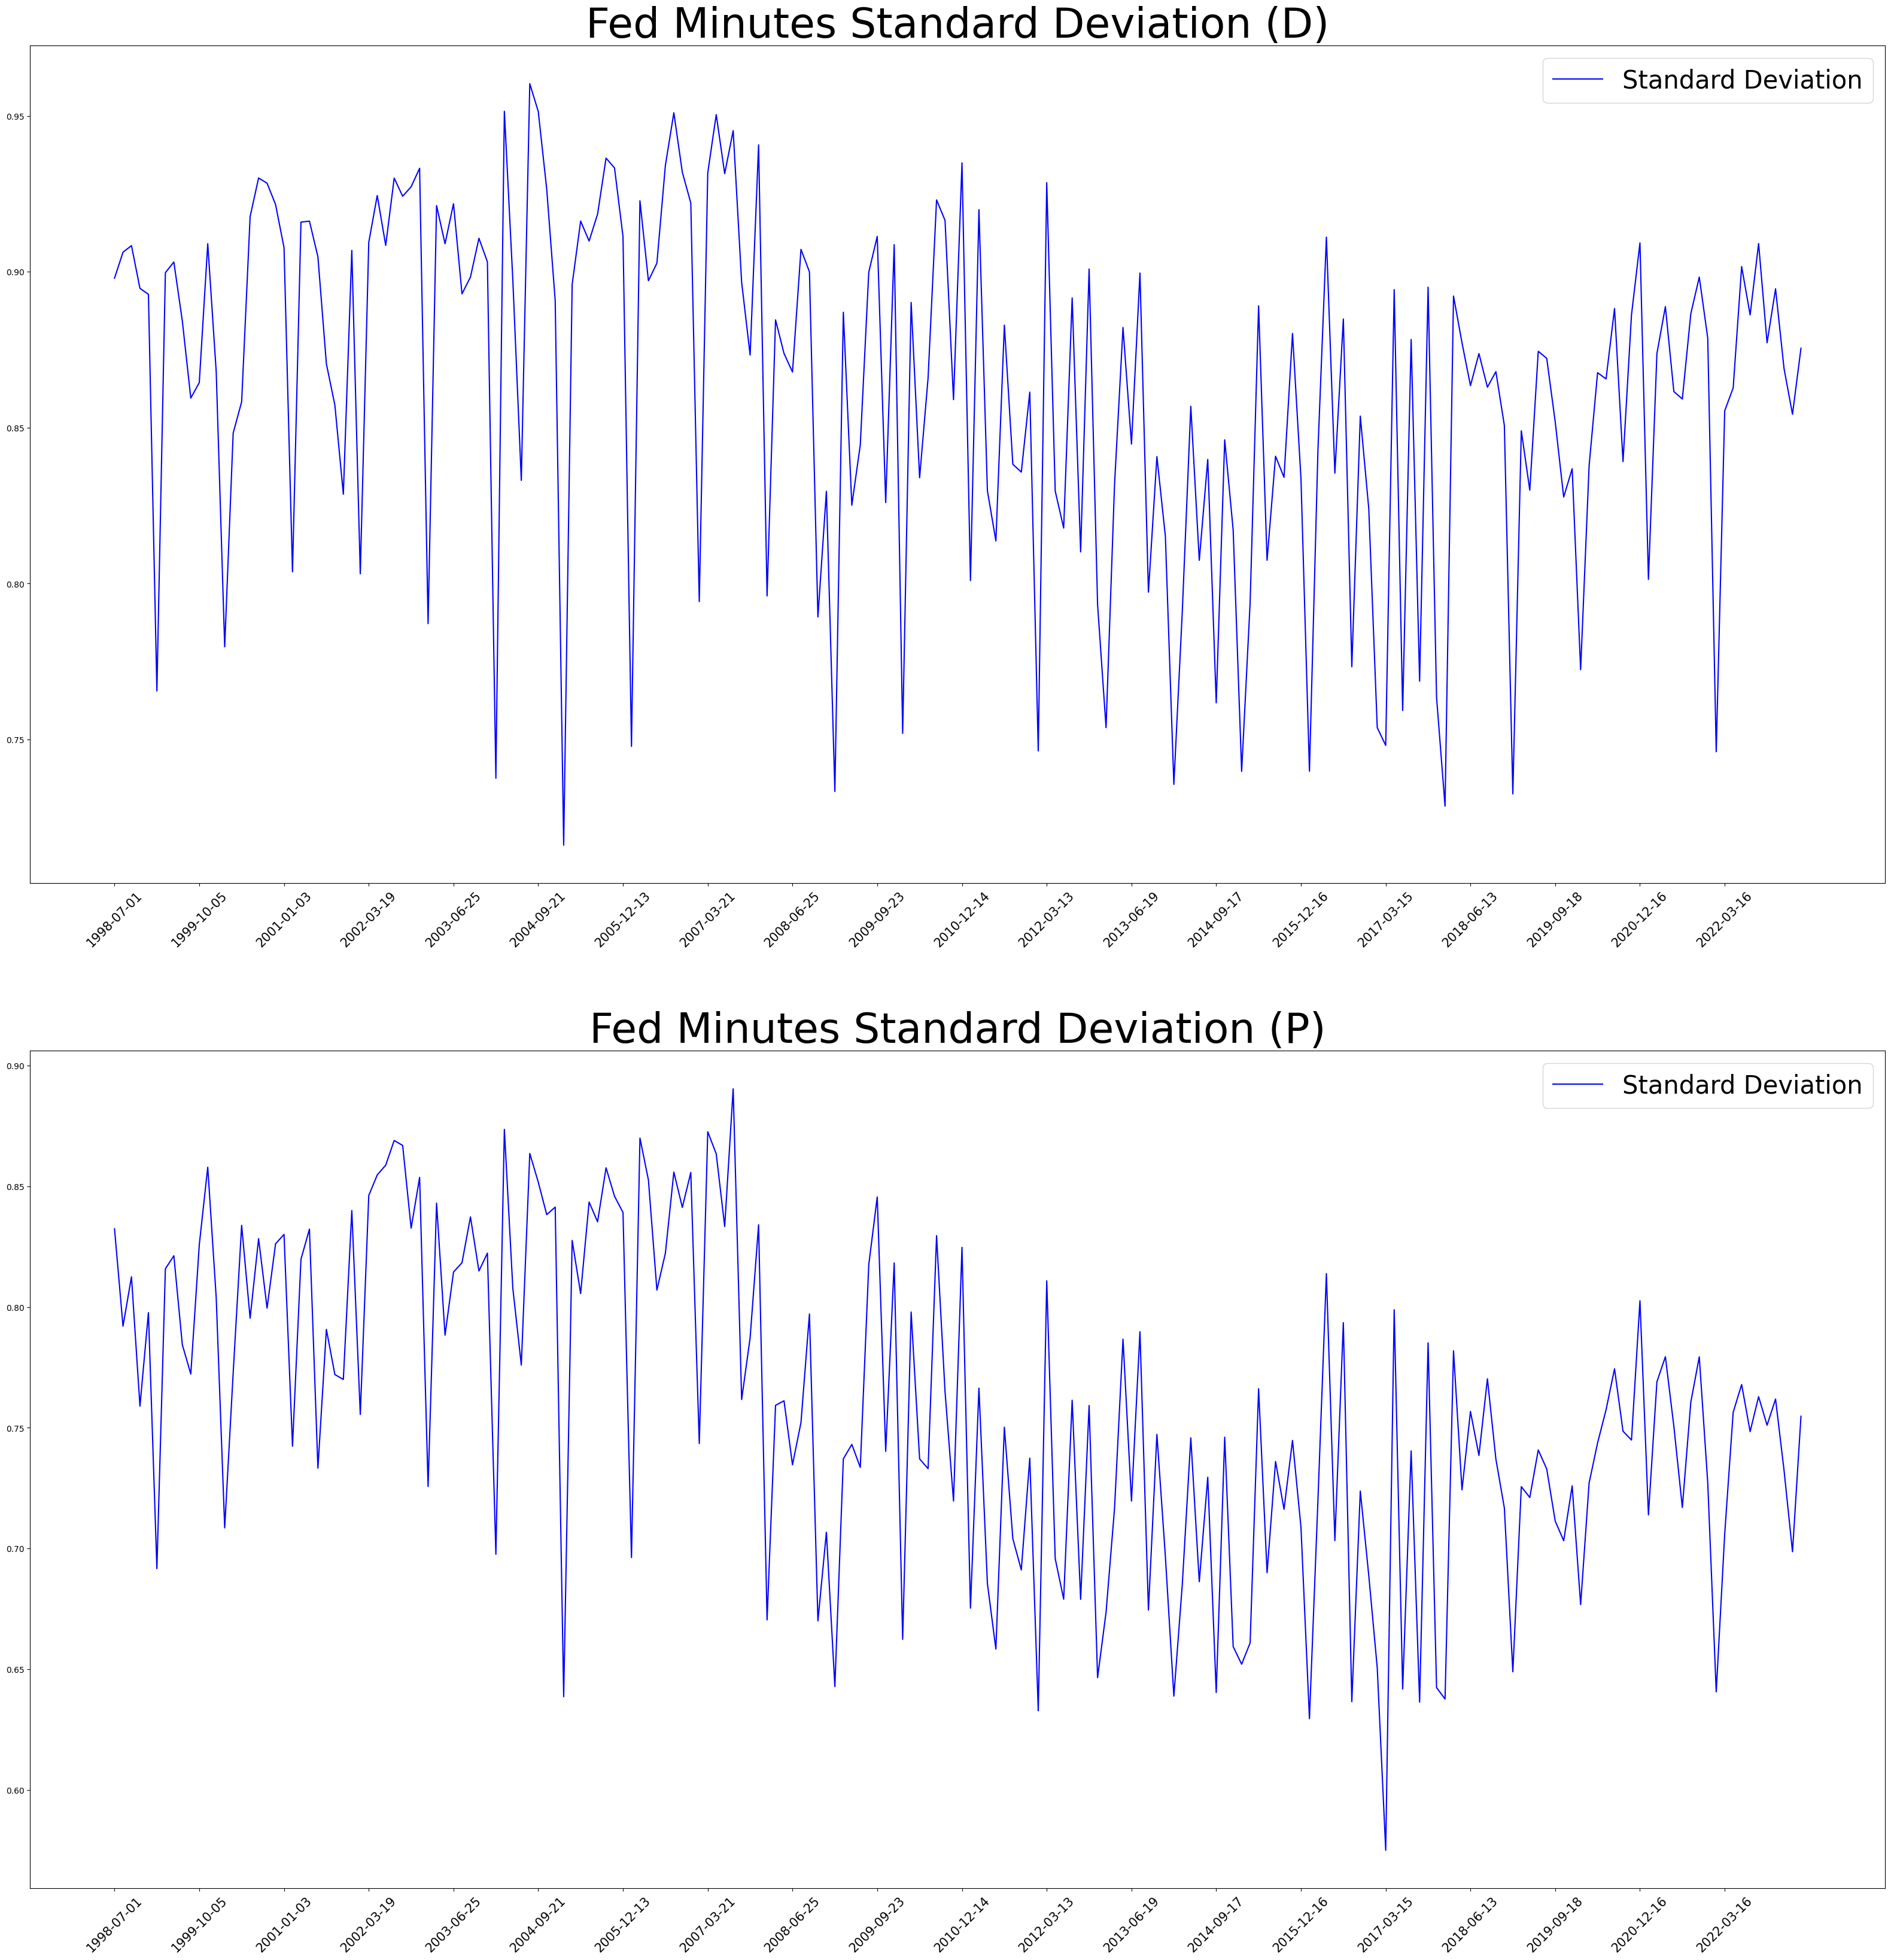

In [20]:
#Create a list of x-axis tick positions
num_ticks = 20  # Adjust this number as needed
x_tick_positions_0 = df_var['date'].iloc[::len(df_var) // num_ticks].tolist()
x_tick_positions_1 = df_var2['date'].iloc[::len(df_var2) // num_ticks].tolist()

fig, axs = plt.subplots(2, 1, figsize=(40, 40))

axs[0].plot(df_var['date'], df_var['sd'], color='blue')
axs[1].plot(df_var2['date'], df_var2['sd'], color='blue')

# Set x-axis ticks for both subplots
axs[0].set_xticks(x_tick_positions_0)
axs[1].set_xticks(x_tick_positions_1)

axs[0].tick_params(axis='x', rotation=45, labelsize=15)
axs[1].tick_params(axis='x', rotation=45, labelsize=15)

axs[0].set_title(f'{Body} {Model} Standard Deviation (D)', fontsize=50)
axs[1].set_title(f'{Body} {Model} Standard Deviation (P)', fontsize=50)

axs[0].legend(["Standard Deviation"], fontsize=30)
axs[1].legend(["Standard Deviation"], fontsize=30)

plt.show()